# Classificatie - Logistic Regression

## Wat is classificatie?

Bij regressie wordt er getracht een manier te zoeken om op basis van een aantal inputs/features een continue waarde te voorspellen.
Bij classificatie omvat machine learning technieken waar een model getrained wordt dat op basis van de input bepaalt in welke categorieen je input thuishoort.
Een model dat een categorie toekent aan een bepaalde set input-data kan ook een **classifier** genoemd worden.
Het classificatieprobleem hoort nog steeds thuis onder **supervised learning** omdat er nog steeds gebruikt gemaakt wordt van een output/label/target om het model te trainen.

Enkele voorbeelden van classificatieproblemen zijn
* Spam detectie
* Medische diagnoses
* Kwaliteitscontrole
* Geschreven tekst inlezen
* ...


## Types van classifiers

Op basis van hoe de data gelabeled wordt kunnen we drie types van classifiers onderscheiden:
* Binaire classifier: Er zijn twee verschillende klasses (goedgekeurd of niet, kwaadaardig vs goedaardig, ...). Lijkt simplistisch maar komt heel veel voor.
* Multiclass classifier: Er zijn een willekeurig aantal klassen en er kan er maar 1 toegekend worden. Een voorbeeld hiervan is gezichtsherkenning (elk gezicht kan maar bij 1 persoon horen).
* Multilabel classifier: Er zijn een willekeurig aantal klassen en 1 input kan tot meerdere klassen behoren, bijvoorbeeld op een foto kan je meerdere zaken herkennen zoals een boom, wolken, gras, struiken, dieren, ...

## Kan hier ook lineaire regressie gebruikt worden?

Een eerste mogelijkheid om classificatie uit te voeren is om elke klasse een apart getal te geven en dan lineaire regressie uit te voeren.
Hierdoor bekomen we een getal en dan kunnen we kijken naar welk cijfer/klasse er het dichts bij licht.
De problemen met deze aanpak kunnen het makkelijkst worden toegelicht doorm iddel van een voorbeeld.
Doorheen deze notebook gaat er grotendeels gewerkt worden met [deze dataset](https://www.kaggle.com/joshmcadams/oranges-vs-grapefruit) die een aantal zaken gemeten heeft over pompelmoesen en sinaasappels.

In [1]:
# imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import opendatasets as od

# graphical
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from ipywidgets import interact, FloatSlider
import matplotlib.animation as animation
import seaborn as sns
sns.set_style("darkgrid")

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier

%matplotlib inline

In [ ]:
od.download("https://www.kaggle.com/joshmcadams/oranges-vs-grapefruit")

In [2]:
df = pd.read_csv(".\\oranges-vs-grapefruit\\citrus.csv")

In [3]:
df["output"] = df.name == "orange"
df

,name,diameter,weight,red,green,blue,output
0,orange,2.96,86.76,172,85,2,True
1,orange,3.91,88.05,166,78,3,True
2,orange,4.42,95.17,156,81,2,True
3,orange,4.47,95.60,163,81,4,True
4,orange,4.48,95.76,161,72,9,True
...,...,...,...,...,...,...,...
9995,grapefruit,15.35,253.89,149,77,20,False
9996,grapefruit,15.41,254.67,148,68,7,False
9997,grapefruit,15.59,256.50,168,82,20,False
9998,grapefruit,15.92,260.14,142,72,11,False


Waneer we nu een scatterplot tekenen van een kleine datasample en lineaire regressie zouden laten uitvoeren bekomen we onderstaand resultaat.
Voor classificatie zouden we beslissen dat wanneer het minder is dan de helft, dat het dan een orange is en anders pompelmoes.

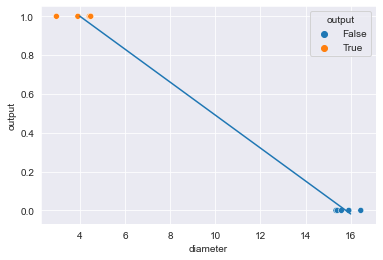

In [8]:
#Neem de eerste 5 oranges en laatste 5 pompelmoesen om de datapunten zo ver mogelijk uit elkaar te hebben
def split(group):
    s = group.sort_values("weight")
    if group.name == "orange":
        return s.head()
    return s.tail()
df_trimmed = df.groupby(["name"]).apply(split)

model = LinearRegression()
model.fit(pd.DataFrame(df_trimmed.diameter), df_trimmed.output)
x_test = [4, 16]
y_test = model.predict(pd.DataFrame(x_test))

sns.scatterplot(x = 'diameter', y ='output', data=df_trimmed, hue='output')
plt.plot(x_test, y_test)

Met deze plot zou je kunnen denken dat lineaire regressie kan gebruikt worden.
Daarom hebben we eens een andere groep ook geplot en daar zie je dat er toch een aantal problemen zijn met lineaire regressie te gebruiken voor classificatie.
* Outliers hebben een grote impact op de trendlijn en dus op de manier dat de classificatie gebeurd
* Als de ene klas 0 is en de andere 1, dan kunnen we waarden voorspellen die kleiner zijn dan 0 en groter dan 1. Dit komt niet overeen met kansen dus is het lastiger om te interpreteren. 
* Als de klassen niet gebalanceerd zijn kan het zijn dat er een grotere bias is voor de ene klassen. Dit wordt ook hieronder. aangetoond.

De combinatie van deze problemen zorgt ervoor dat lineaire regressie zelden een goede oplossing is voor classificatieproblemen.
Gelukkig bevat het domein van classificatie een hele hoop machine learning technieken die beter bestand zijn tegen deze problemen.
In de loop van de cursus gaan we er een aantal van bestuderen, namelijk:
* Logistic Regression
* SVM
* Naive Bayes
* Decision Trees
* Random Forest

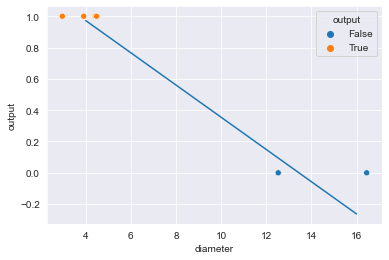

In [10]:
# Voeg de tail(1) toe om een outlier te introduceren aan de vorige versie
def split_outlier(group):
    s = group.sort_values("weight")
    if group.name == "orange":
        return s.head()
    return pd.concat([s.tail(1), s[-1000:-995]])
df_trimmed = df.groupby(["name"]).apply(split_outlier)

model = LinearRegression()
model.fit(pd.DataFrame(df_trimmed.diameter), df_trimmed.output)
x_test = [4, 16]
y_test = model.predict(pd.DataFrame(x_test))

sns.scatterplot(x = 'diameter', y ='output', data=df_trimmed, hue='output')
plt.plot(x_test, y_test)

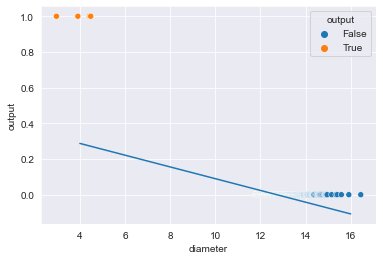

In [11]:
# een veel grotere groep van de ene klasse trekt de lijn naar benden
def split_inbalanced(group):
    s = group.sort_values("weight")
    if group.name == "orange":
        return s.head()
    return s.tail(2000)
df_trimmed = df.groupby(["name"]).apply(split_inbalanced)

model = LinearRegression()
model.fit(pd.DataFrame(df_trimmed.diameter), df_trimmed.output)
x_test = [4, 16]
y_test = model.predict(pd.DataFrame(x_test))

sns.scatterplot(x = 'diameter', y ='output', data=df_trimmed, hue='output')
plt.plot(x_test, y_test)

## Logistic Regression

De eerste classificatietechniek die aan bod komt is logistic regression.
De naam is wat ongelukkig omdat het verkeerdelijk aangeeft dat het gebruikt wordt voor regressie maar eigenlijk geeft het aan dat een aanpassing is van lineaire regressie om het classificatieprobleem aan te pakken.
Deze techniek is een **binaire classifier**.

Net zoals bij lineaire regressie gaan we opnieuw een reeks features van een aantal observaties gebruiken om een bepaalde output te genereren.
Het verschil is dat we nu niet streven naar een continue waarde correct te voorspellen maar het model moet 1 geven als de observatie tot de klasse hoort en anders 0.
Het resultaat van het model gaat een continue getal tussen 0 en 1 zijn dat de kans weergeeft dat de observatie tot de klasse hoort. 

In principe is de keuze van functie vrij zolang dat het bereik van deze functie tussen 0 en 1 blijft maar bij logistic regression wordt er gekozen voor de logistische functie (vandaar de naam). Deze is gedefinieerd als:

$f(z) = \frac{1}{1+e^{-z}}$

en ziet er uit als volgt:

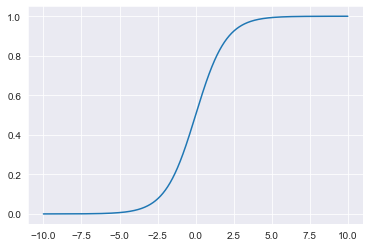

In [7]:
x = np.linspace(-10, 10, 1000)
y = 1 / (1+np.exp(-x))
plt.plot(x,y)

Om deze te gebruiken in het model gaan we in plaats van z een lineaire combinatie maken van de gewichten en de inputs (net zoals de functie bij lineaire regressie). De uiteindelijke notatie is:

$f_{\boldsymbol{w}}(x) = \frac{1}{1+e^{-\boldsymbol{w}^Tx}}$

In deze notatie stelt x de featurevector voor en $\boldsymbol{w}$ de gewichtenvector. De transpose van de ene vector is nodig om de ze kunnen vergelijken. Deze vermenigvuldingen van matrices is gelijk aan de functie die we trachten te voorspellen bij lineaire regressie, namelijk:

$\boldsymbol{w}^Tx = w_0 + w_1x_1 + w_2x_2 + ... + w_Nx_N$

### Grafische interpretatie

Indien we twee features bekijken in een scatterplot, dan zoekt logistische regressie naar de beste rechte/curve die de verdeelt zodat zoveel mogelijk observaties van de klassen langs dezelfde kant van de curve liggen. Bijvoorbeeld:

<AxesSubplot:xlabel='diameter', ylabel='blue'>

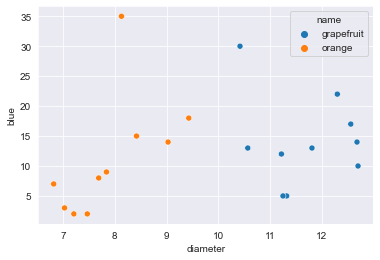

In [16]:
def split_linear(group):
    if group.name == "orange":
        # hier heb ik wat extra filtering toegevoegd om niet overlappende klassen te krijgen
        s = group[group.blue > (12.5*group.diameter-100)]
        return s.sample(10)
    # hier heb ik wat extra filtering toegevoegd om niet overlappende klassen te krijgen
    s = group[group.blue < (12.5*group.diameter-100)]
    return s.sample(10)
df_trimmed = df.groupby(["name"]).apply(split_linear)

model = LogisticRegression()
model.fit(pd.DataFrame(df_trimmed.diameter), df_trimmed.output)

sns.scatterplot(x = 'diameter', y ='blue', data=df_trimmed, hue='name')

Het tweede deel na het opstellen hoe de predicties gemaakt worden is het definieren van de kostenfunctie.
Deze functie gaan we proberen te minimaliseren. Omdat we nu geen continue waarde als output en de functie logistische kunnen we niet meer gebruik maken van de LMS-functie van lineaire regressie. 
Daarom maken we gebruik van onderstaande kostenfunctie:

$L(\boldsymbol{w}) = \begin{cases}
  -ln(f_{\boldsymbol{w}}(x)) & \text{als }y=1\\    
  -ln(1-f_{\boldsymbol{w}}(x)) & \text{als }y=0
\end{cases}$

$L(\boldsymbol{w}) = -\frac{1}{N}\Bigg[\sum\limits_{i=1}^{N}
y_i ln(f_{\boldsymbol{w}}(x_i))
+ (1-y_i) ln(1-f_{\boldsymbol{w}}(x_i))
\Bigg]$

De kostfunctie van een label dat y=1 had ziet er uit als volgt:

<ipython-input-9-1ed193853ed5>:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(x, -np.log(x))


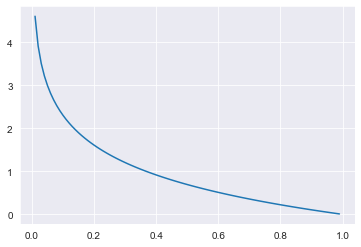

In [9]:
x = np.arange(0, 1, 0.01)
plt.plot(x, -np.log(x))

De optimalisatie hiervan kan terug gebeuren door middel van Gradient Descent.

### Meervoudige classificatie

Bovestaande figuur omvat onmiddelijk meervoudige classificatie (gebruik van meerdere features) omdat er zowel een feature op de x-as en y-as staat.
Het uitvoeren van logistische regressie heeft dan het volgende resultaat:

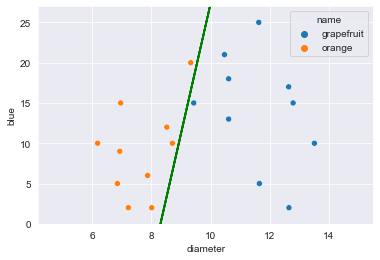

In [10]:
model = LogisticRegression(C=1e5) # C= inverse regularisatiesterkte
model.fit(df_trimmed[["diameter", "blue"]], df_trimmed.output)

# all points in the plot
# Definieer een bereik op de x en y-as
step = 0.01
x_min = df_trimmed.diameter.min()-2
x_max = df_trimmed.diameter.max()+2
y_min = df_trimmed.blue.min()-2
y_max = df_trimmed.blue.max()+2

# Dubbele for-loop voor x van xmin naar xmax in stapjes van 0.01 en idem voor y
xx, yy = np.meshgrid(np.arange(x_min, x_max, step),np.arange(y_min, y_max, step))

# make prediction for all points in het domein [x_min, x_max] en beeld [y_min, y_max]
predicts = model.predict(np.c_[xx.ravel(), yy.ravel()])
predicts = predicts.reshape(xx.shape)

sns.scatterplot(x = 'diameter', y ='blue', data=df_trimmed, hue='name')
# find dividing boundary (teken de groene lijn)
plt.contour(xx, yy, predicts, colors='green')   

### Hogere orde features 

Net zoals bij lineaire regressie is het niet steeds mogelijk om een rechte te gebruiken om een goede splitsen van de klassen te bekomen.
Denk bijvoorbeeld aan kwaliteitscontroles waar de breedte en lengte van een component aan bepaalde tolerantiewaarden moet voldoen. 
Wanneer je een scatterplot maakt van de goede en slechte componenten dan bekom je typisch een cirkel of ovaal uit om de classificatie uit te voeren, een voorbeeld zie je hieronder:

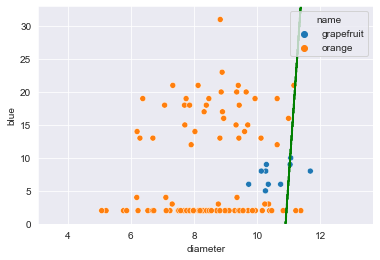

In [17]:
def split_circle(group):
    if group.name == "orange":
        # wat filtering om een cirkel te bekomen
        s = group[(group.blue-8)**2 + (group.diameter -8)**2 > 16]
        return s.sample(100)
    # wat filtering om een cirkel te bekomen
    s = group[(group.blue-8)**2 + (group.diameter -8)**2 < 16]
    return s.sample(10)
df_trimmed = df.groupby(["name"]).apply(split_circle)

model = LogisticRegression(C=1e5) # C= inverse regularisatiesterkte
model.fit(df_trimmed[["diameter", "blue"]], df_trimmed.output)

# all points in the plot
step = 0.01
x_min = df_trimmed.diameter.min()-2
x_max = df_trimmed.diameter.max()+2
y_min = df_trimmed.blue.min()-2
y_max = df_trimmed.blue.max()+2
xx, yy = np.meshgrid(np.arange(x_min, x_max, step),np.arange(y_min, y_max, step))

# make prediction for all points
predicts = model.predict(np.c_[xx.ravel(), yy.ravel()])
predicts = predicts.reshape(xx.shape)

sns.scatterplot(x = 'diameter', y ='blue', data=df_trimmed, hue='name')
# find dividing boundary
plt.contour(xx, yy, predicts, colors='green')   

Het is duidelijk op bovenstaande figuur dat de classificatie met een rechte niet kan gebeuren. 
De oplossing hiervoor is om hogere orde features toe te voegen (net zoals bij lineaire regressie).
Omdat er hier gefilterd is op een cirkel, is er genoeg met tweede-orde features. 
Dit geeft het volgende resulaat:

C:\Users\jens.baetens3\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


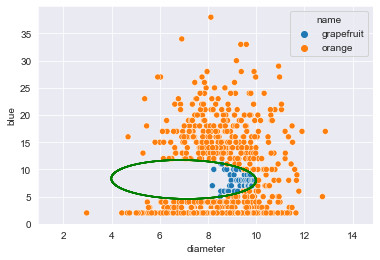

In [18]:
def split_circle(group):
    if group.name == "orange":
        s = group[(group.blue-8)**2 + (group.diameter -6)**2 > 16]
        return s.sample(1000)
    s = group[(group.blue-8)**2 + (group.diameter -6)**2 < 16]
    return s
df_trimmed = df.groupby(["name"]).apply(split_circle)

# cirkle is van de vorm x^2 +y^2 dus graad 2
graad = 2
poly = PolynomialFeatures(graad)
X = poly.fit_transform(df_trimmed[["diameter", "blue"]])

model = LogisticRegression(C=1000000000000) # C= inverse regularisatiesterkte
model.fit(X, df_trimmed.output)

# all points in the plot
step = 0.01
x_min = df_trimmed.diameter.min()-2
x_max = df_trimmed.diameter.max()+2
y_min = df_trimmed.blue.min()-2
y_max = df_trimmed.blue.max()+2
xx, yy = np.meshgrid(np.arange(x_min, x_max, step),np.arange(y_min, y_max, step))

# higher orders for all points
xx_higher = np.hstack((xx.reshape(-1,1),yy.reshape(-1,1)))
xx_higher = poly.fit_transform(xx_higher)

# make prediction for all points
predicts = model.predict(xx_higher)
predicts = predicts.reshape(xx.shape)

sns.scatterplot(x = 'diameter', y ='blue', data=df_trimmed, hue='name')
# find dividing boundary
plt.contour(xx, yy, predicts, colors='green')   

Net zoals bij lineaire regressie, kan het gebruiken van hogere orde-features tot niet gewenste resultaat leiden.
Hiervoor moet er opnieuw regressie toegevoegd worden.
Dit kan door middel van de C-parameter in de constructor van het model mee te geven.
Deze parameter geeft de toegelaten complexiteit van de classifier weer.
Deze parameter is het inverse van de $\alpha$ bij Ridge en Lasso Regression:
* Een hoge C-waarde doet hetzelfde als een lage $\alpha$ waarde en zorgt voor weinig regularisatie.
* Een lage C-waarde doet hetzelfde als een hoge $\alpha$ waarde en zorgt voor een sterke regularisatie.

C:\Users\jens.baetens3\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


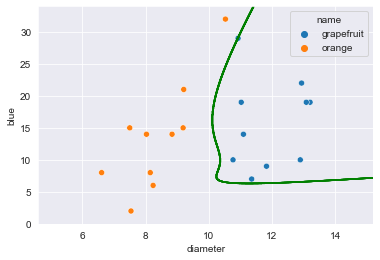

In [31]:
# er wordt gesplits volgens een graad 3
def split_third_order(group):
    x = group.diameter
    if group.name == "orange":
        s = group[group.blue > (12.5*group.diameter-100)]
        return s.sample(10)
    s = group[group.blue < (12.5*group.diameter-100)]
    return s.sample(10)
df_trimmed = df.groupby(["name"]).apply(split_third_order)

# heel hoge graad zodat er overfitting is
graad = 8
poly = PolynomialFeatures(graad)
X = poly.fit_transform(df_trimmed[["diameter", "blue"]])

model = LogisticRegression(C=0.2) # C= inverse regularisatiesterkte
model.fit(X, df_trimmed.output)

# all points in the plot
step = 0.01
x_min = df_trimmed.diameter.min()-2
x_max = df_trimmed.diameter.max()+2
y_min = df_trimmed.blue.min()-2
y_max = df_trimmed.blue.max()+2
xx, yy = np.meshgrid(np.arange(x_min, x_max, step),np.arange(y_min, y_max, step))

# higher orders for all points
xx_higher = np.hstack((xx.reshape(-1,1),yy.reshape(-1,1)))
xx_higher = poly.fit_transform(xx_higher)

# make prediction for all points
predicts = model.predict(xx_higher)
predicts = predicts.reshape(xx.shape)

sns.scatterplot(x = 'diameter', y ='blue', data=df_trimmed, hue='name')
# find dividing boundary
plt.contour(xx, yy, predicts, colors='green')   

<ipython-input-32-175f0ee90902>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, predicts, cmap="Accent")


<AxesSubplot:xlabel='diameter', ylabel='blue'>

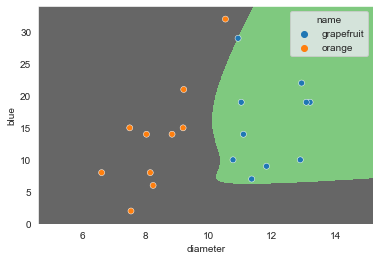

In [32]:
# let hier op - volgorde is belangrijk anders wordt de colormesh boven de scatterplot getekend
plt.pcolormesh(xx, yy, predicts, cmap="Accent")
sns.scatterplot(x = 'diameter', y ='blue', data=df_trimmed, hue='name')

## Evaluatie van classificatie

In tegenstelling tot lineaire regressie kunnen we niet de afstand tot de gewenste output gebruiken om verschillende classifiers te gaan evalueren.
Een mogelijkheid die kan werken is om te kijken naar het percentage van inputs die correct geklassificieerd zijn.
Dit wordt ook de accuraatheid of accuracy genoemd.
Enkel deze metriek gebruiken heeft echter problemen bij het classificieren van zeldzame events of niet-gebalanceerde data.
Een classifier zou bijvoorbeeld voor iets dat in maar 1 van de 1000 gevallen voorkomt kunnen voorspellen dat het nooit voorkomt maar toch een accuraatheid bekomen van 99,9%.

Om dit op te vangen kan de zogenoemde [confusionmatrix](https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826) bepaald worden.
Hierin wordt bijgehouden voor elke klasse hoeveel voorspellingen er correct waren en hoeveel niet.
Op basis van deze matrix kunnen de volgende metrieken berekend worden:
* Accuraatheid: algemene correctheid $\frac{TP+TN}{TP+TN+FP+FN}$
* Precisie: Accuraatheid binnen positieve testen $\frac{TP}{TP+FN}$
* Specificiteit: Accuraatheid binnen negatieve samples $\frac{TN}{TN+FP}$
* Recall: Accuraatheid binnen positieve samples $\frac{TP}{TP+FN}$
* F1-score: Combinatie Precisie en Recall: $2\frac{Precisie*Recall}{Precisie+Recall} = \frac{2TP}{2TP+FP+FN}$

De [.score](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.score) functie van het LogisticRegression model berekend de accuraatheid van het model maar de andere metrieken kunnen een veel nauwkeuriger beeld geven over de correcte werken van het model.

![matrix](images/confusionMatrix.png)

In [ ]:
from sklearn.metrics import precision_score

precision_score(y_test, y_pred)

## Multi-class classification

In het bovenstaande voorbeeld zijn de training examples onderverdeeld in twee klassen.
In de praktijk komt het ook vaak voor dat er meerdere klasses mogelijk zijn, zoals meerdere types fruit, meerdere soorten hondenrassen, ...
Om dit aan te pakken zijn er twee veelgebruikte technieken: One vs All en One vs One.
Meer informatie over hoe de LogisticRegression van sklearn kan gebruikt worden voor multi-class problemen op te lossen vind je [hier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
Dan gaat het specifiek om het multi-class probleem.

### One vs All

Bij deze techniek maak 1 classifier per klasse die je hebt.
Deze classifier bepaalt of een input van die bepaalde klasse is of niet.
Met deze techniek worden er dus N classifiers getrained.
Het voordeel hiervan is dat er minder classifiers nodig zijn dan in de One-Vs-One-techniek waardoor het sneller te trainen is.
Het nadeel echter is dat de techniek gevoeliger is aan niet-gebalanceerde data.
Deze techniek wordt ook vaak One-Vs-The-Rest genoemd.

Een opmerking bij techniek is dat het mogelijk is dat twee of meerdere classifiers aangeven dat een input tot die klasse hoort.
In het geval dat er een dergelijk conflict opduikt wordt de klasse die de hoogste kans aangeeft gekozen. 

![onevsall](images/oneVsAll.png)

### One vs One

Bij deze techniek maken we een classifier aan voor elke combinatie van 2 klassen aan. 
Hierdoor zijn er $\frac{N(N-1)}{2}$ classifiers nodig wat snel kan oplopen in vergelijking met de voorgaande techniek.
Op basis van onderstaand voorbeeld werkt deze techniek als volgt:
* Eerst wordt er gekeken of de input van de rode of de blauwe klasse is. 
* Indien het niet van de rode is, wordt er nog gekeken of het blauw of groen is.
* Indien het niet de blauwe klasse is, wordt er nog gekeken of het rood of groen is.

Hoewel deze methode een grotere trainingstijd nodig heeft door het toegenomen aantal classifiers zijn er wel een aantal voorbeelden:
* Minder gevoelig voor niet gebalanceerde data
* Geen wazige gebieden waar meerdere classifiers kunnen voorspellen dat het van die klasse is.

![onevsall](images/oneVsOne.png)

In [ ]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier

### Multiclass evaluatie

De confusion matrix in het geval van meerdere klassen kan uitgebreid worden naar onderstaand voorbeeld voor drie klassen. 

![matrix](images/confusionMatrixMulti.png)

Hier is het niet rechtstreeks zichtbaar wat de True Positive, True Negative, ... waarden zijn.
We kunnen deze echter eenvoudig berekenen per klasse. 
Dan kunnen we de besproken metrieken ook per klasse berekenen zodat we onderstaande resultaten bekomen.

![matrix](images/metriekenMulti.png)

Met behulp van deze matrix kunnen verschillende modellen vergeleken worden.
Echter kan er nog iets verder gegaan worden in het combineren van waarden door een globale F1-score te bepalen.
Hier zijn meerdere opties voor, namelijk:
* Micro F1: Globale F1 op basis van total TP, FN en FP. Merk op dat door geen onderscheid te maken tussen klassen dat $Micro F1 = Precisie = Recall = Accuraatheid$
* Macro F1: (Niet gewogen) Gemiddelde van alle F1-scores per klasse.
* Weighted F1: Gewogen gemiddelde van de F1-scores per klasse (gewichten = aantal samples van die klasse)

## Voorbeeld

Gebruik nu [deze dataset](https://www.kaggle.com/c/titanic/overview) om onderstaande vragen op te lossen:
* Maak een model om op basis van de kolommen te voorspellen of een bepaalde passagier de tocht op de titanic zou overleven
* Bereken voor dit model de accuraatheid, specificiteit, recall, precisie en F1-score. 
* Probeer hogere-orde features te gebruiken om deze waarden te verhogen
* Maak een scatter plot voor de leeftijd vs hoeveel er betaald was voor het ticket. Geef ook aan welke datapunten de ramp overleefd hebben en welke niet.
* Duid op deze plot de scheidingslijn tussen overleving en niet overleving aan voor het beste gevonden model.
* Maak nu een one-vs-all en one-vs-one classifier aan om de klasse van een persoon te voorspellen op basis van de andere gegevens. Gebruik hiervoor niet de testset omdat hier geen data voor beschikbaar is in de testset maar splits je trainingsset op in twee delen.
* Schrijf nu een functie om de confusion matrix en de metrieken per klasse en de gecombineerde F1-scores te bepalen. Zoek naar het beste model.
* Welke hyperparameters heb je gebruikt tijdens het zoeken naar het model? Hoeveel parameters/gewichten heeft je uiteindelijke model?

In [25]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

In [28]:
df_train = pd.read_csv(".\\titanic\\train.csv")
# drop kolommen
df_train.drop(["PassengerId", "Name", "Ticket"], axis=1, inplace=True)

# fix null-values
df_train.fillna({"Age":-1, "Cabin":"unknown", "Embarked":"unknown"}, inplace=True)

# text omzetten naar cijfers

encoder = OrdinalEncoder()
categorieke_data = df_train.select_dtypes("object").columns
df_train[categorieke_data] = encoder.fit_transform(df_train[categorieke_data])

# welke kolommen hebben null-waarden
df_train.isna().sum()

# welke kolommen zijn geen cijfers
#df_train.info()

y = df_train.Survived
X = df_train.drop("Survived", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# doe scaling om de waarschuwing over MAX_ITER_REACHED te vermijden
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# doe hier geen fit om data leakage te vermijden (niets van test-data gebruiken voor trainen model)
X_test = scaler.transform(X_test)

print(X_test)

print(X_train.shape, y_train.shape)

[[-0.38079633  0.73712455  1.71598357 -0.47528316 -0.47167383 -0.36387026
   0.45015271  0.57255588]
 [-0.38079633  0.73712455  2.62500572 -0.47528316 -0.47167383 -0.43316457
   0.45015271  0.57255588]
 [ 0.82006138 -1.35662284 -0.72701344  3.11624338  1.9737031  -0.02185337
   0.45015271  0.57255588]
 [-0.38079633 -1.35662284 -1.06789675  0.42259847  1.9737031  -0.09164264
   0.45015271  0.57255588]
 [ 0.82006138 -1.35662284  0.69333366  0.42259847 -0.47167383 -0.2965558
   0.45015271  0.57255588]
 [-0.38079633  0.73712455 -0.04524683 -0.47528316 -0.47167383 -0.38366864
   0.45015271  0.57255588]
 [-1.58165404  0.73712455  0.01156705 -0.47528316  0.75101464  4.25946162
  -2.63832077 -1.96825996]
 [-1.58165404 -1.35662284  0.12519482 -0.47528316 -0.47167383  0.92005422
   0.45015271  0.57255588]
 [ 0.82006138 -1.35662284 -1.40878005 -0.47528316 -0.47167383 -0.48167058
   0.45015271  0.57255588]
 [-1.58165404  0.73712455  1.77279746 -0.47528316 -0.47167383 -0.03719711
  -1.85924637  0.5

In [35]:
model = LogisticRegression(C=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
model.score(X_test, y_test)

0.7888888888888889

In [32]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82        56
           1       0.69      0.74      0.71        34

    accuracy                           0.78        90
   macro avg       0.76      0.77      0.77        90
weighted avg       0.78      0.78      0.78        90

